In [1]:
import torch

### Creating a graph in PyTorch

In [2]:
def compute_z(a,b,c):
    r1 = torch.sub(a,b)
    r2 = torch.mul(r1,2)
    z = torch.add(r2,c)
    return z

print('Scalar Inputs:', compute_z(torch.tensor(1), torch.tensor(2), torch.tensor(3)))
print('Rank 1 Inputs:', compute_z(torch.tensor([1]), torch.tensor([2]), torch.tensor([3])))
print('Rank 2 Inputs:', compute_z(torch.tensor([[1]]), torch.tensor([[2]]), torch.tensor([[3]])))

Scalar Inputs: tensor(1)
Rank 1 Inputs: tensor([1])
Rank 2 Inputs: tensor([[1]])


### Tensor objects for storing and updating model parameters

In [3]:
a = torch.tensor(3.14, requires_grad=True)
print(a)

tensor(3.1400, requires_grad=True)


In [4]:
b = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
print(b)

tensor([1., 2., 3.], requires_grad=True)


In [5]:
w = torch.tensor([1.0, 2.0, 3.0])
print(w.requires_grad)

False


In [6]:
w.requires_grad_()
print(w.requires_grad)

True


### Glorot Initialization

In [7]:
SEED = 42

In [8]:
import torch.nn as nn

torch.manual_seed(SEED)
w = torch.empty(2,3) #create empty tensor
nn.init.xavier_normal_(w) #fill with values according to Glorot init
print(w)

tensor([[ 0.2129,  0.0815,  0.1483],
        [ 0.1457, -0.7102, -0.1178]])


In [9]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.w1 = torch.empty(2,3,requires_grad=True)
        nn.init.xavier_normal_(self.w1)
        self.w2 = torch.empty(1,2,requires_grad=True)
        nn.init.xavier_normal_(self.w2)

### Computing gradients via autodiff

In [10]:
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True) 
x = torch.tensor([1.4])
y = torch.tensor([2.1])
z = torch.add(torch.mul(w, x), b)
 
loss = (y-z).pow(2).sum()
loss.backward()

print('dL/dw : ', w.grad)
print('dL/db : ', b.grad)

dL/dw :  tensor(-0.5600)
dL/db :  tensor(-0.4000)


In [11]:
#verifying the computed gradient
print(2 * x * ((w * x + b) - y))

tensor([-0.5600], grad_fn=<MulBackward0>)


### Simplifying implementations of common architectures via torch.nn

In [15]:
model = nn.Sequential(
nn.Linear(4,16),
nn.ReLU(),
nn.Linear(16,32),
nn.ReLU()
)

model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

In [17]:
nn.init.xavier_uniform_(model[0].weight)
l1_weight = 0.01
l1_penalty = l1_weight * model[2].weight.abs().sum()

In [18]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)

### XOR problem

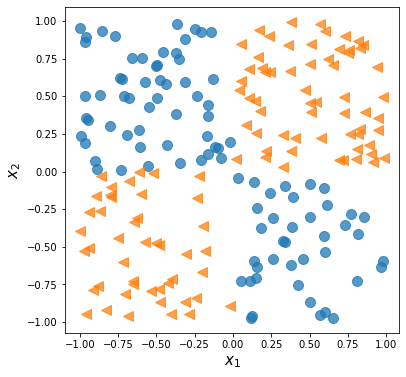

In [48]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


np.random.seed(1)
torch.manual_seed(1)
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], 
         x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], 
         x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.show()

In [49]:
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)

model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [50]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)

In [51]:
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [52]:
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.mean()

        loss_hist_train[epoch] /= n_train/batch_size
        accuracy_hist_train[epoch] /= n_train/batch_size

        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        accuracy_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

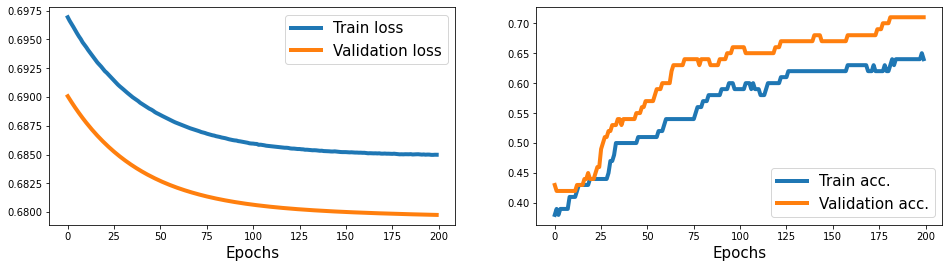

In [53]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

In [54]:
model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)
 
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)

In [55]:
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

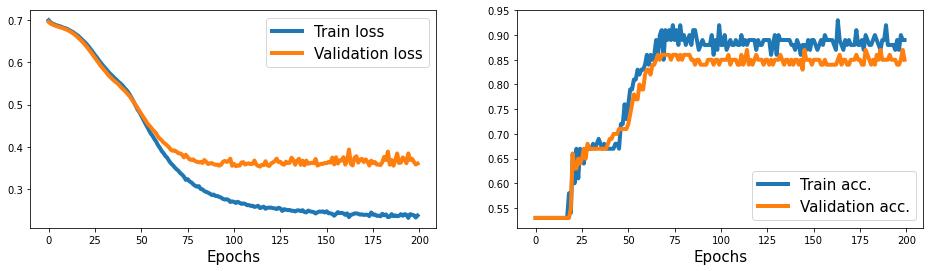

In [56]:
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

### Model building with nn.Module

In [61]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2,4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4,4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4,1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)
    
    def forward(self, x):
        for f in self.module_list:
            x = f(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()

In [62]:
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [59]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
history = train(model, num_epochs, train_dl, x_valid, y_valid)

In [60]:
conda install mlxtend -c conda-forge

Solving environment: done

## Package Plan ##

  environment location: /Users/niekvanderzwaag/opt/anaconda3

  added / updated specs:
    - mlxtend


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2021.10.8          |   py38h50d1736_2         145 KB  conda-forge
    conda-4.12.0               |   py38h50d1736_0        1020 KB  conda-forge
    mlxtend-0.19.0             |     pyhd8ed1ab_0         1.2 MB  conda-forge
    openssl-1.1.1o             |       hfe4f2af_0         1.9 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.3 MB

The following NEW packages will be INSTALLED:

  mlxtend            conda-forge/noarch::mlxtend-0.19.0-pyhd8ed1ab_0

The following packages will be UPDATED:

  openssl              pkgs/main::openssl-1.1.1n-hca72f7f_0 --> conda-forge::openssl-1.1.1o-hfe4f2af_0

T

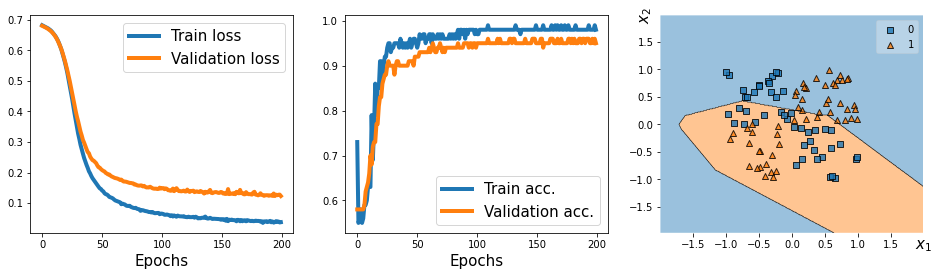

In [63]:
from mlxtend.plotting import plot_decision_regions

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

### Predicting Fuel Efficiency of a Car

In [65]:
import pandas as pd

url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv(url, names=column_names,
                 na_values = "?", comment='\t',
                 sep=" ", skipinitialspace=True)

df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [66]:
df.shape

(398, 8)

In [67]:
df.describe

<bound method NDFrame.describe of       MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0    18.0          8         307.0       130.0  3504.0          12.0   
1    15.0          8         350.0       165.0  3693.0          11.5   
2    18.0          8         318.0       150.0  3436.0          11.0   
3    16.0          8         304.0       150.0  3433.0          12.0   
4    17.0          8         302.0       140.0  3449.0          10.5   
..    ...        ...           ...         ...     ...           ...   
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
0            70       1  
1            70       1  
2            70       1

In [74]:
df[df['Horsepower'].isna()]

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
32,25.0,4,98.0,NaN,2046.0,19.0,71,1
126,21.0,6,200.0,NaN,2875.0,17.0,74,1
330,40.9,4,85.0,NaN,1835.0,17.3,80,2
336,23.6,4,140.0,NaN,2905.0,14.3,80,1
354,34.5,4,100.0,NaN,2320.0,15.8,81,2
374,23.0,4,151.0,NaN,3035.0,20.5,82,1


In [75]:
df = df.dropna().reset_index(drop=True)

In [76]:
import sklearn
import sklearn.model_selection
df_train, df_test = sklearn.model_selection.train_test_split(df, train_size=0.8, random_state=1)
train_stats = df_train.describe().transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
MPG,313.0,23.404153,7.666909,9.0,17.5,23.0,29.0,46.6
Cylinders,313.0,5.402556,1.701506,3.0,4.0,4.0,8.0,8.0
Displacement,313.0,189.512780,102.675646,68.0,104.0,140.0,260.0,455.0
Horsepower,313.0,102.929712,37.919046,46.0,75.0,92.0,120.0,230.0
Weight,313.0,2961.198083,848.602146,1613.0,2219.0,2755.0,3574.0,5140.0
Acceleration,313.0,15.704473,2.725399,8.5,14.0,15.5,17.3,24.8
Model Year,313.0,75.929712,3.675305,70.0,73.0,76.0,79.0,82.0
Origin,313.0,1.591054,0.807923,1.0,1.0,1.0,2.0,3.0


In [77]:
numeric_column_names = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration']

df_train_norm, df_test_norm = df_train.copy(), df_test.copy()

for col_name in numeric_column_names:
    mean = train_stats.loc[col_name, 'mean']
    std  = train_stats.loc[col_name, 'std']
    df_train_norm.loc[:, col_name] = (df_train_norm.loc[:, col_name] - mean)/std
    df_test_norm.loc[:, col_name] = (df_test_norm.loc[:, col_name] - mean)/std
    
df_train_norm.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
334,27.2,-0.824303,-0.530922,-0.499214,-0.555264,-0.001641,81,1
258,18.6,0.351127,0.345625,0.186457,0.776338,1.099115,78,1
139,29.0,-0.824303,-0.891280,-0.525586,-0.874613,0.291894,74,2
310,37.2,-0.824303,-1.008153,-1.000281,-1.110294,0.255202,80,3
349,33.0,-0.824303,-0.823104,-0.762934,-0.908786,-0.552019,81,2


In [78]:
boundaries = torch.tensor([73, 76, 79])
v = torch.tensor(df_train_norm['Model Year'].values)
df_train_norm['Model Year Bucketed'] = torch.bucketize(v, boundaries, right=True)

v = torch.tensor(df_test_norm['Model Year'].values)
df_test_norm['Model Year Bucketed'] = torch.bucketize(v, boundaries, right=True)

numeric_column_names.append('Model Year Bucketed')

In [88]:
from torch.nn.functional import one_hot

total_origin = len(set(df_train_norm['Origin']))

origin_encoded = one_hot(torch.from_numpy(df_train_norm['Origin'].values) % total_origin)
x_train_numeric = torch.tensor(df_train_norm[numeric_column_names].values)
x_train = torch.cat([x_train_numeric, origin_encoded], 1).float()
 
origin_encoded = one_hot(torch.from_numpy(df_test_norm['Origin'].values) % total_origin)
x_test_numeric = torch.tensor(df_test_norm[numeric_column_names].values)
x_test = torch.cat([x_test_numeric, origin_encoded], 1).float()

In [89]:
y_train = torch.tensor(df_train_norm['MPG'].values).float()
y_test = torch.tensor(df_test_norm['MPG'].values).float()

In [90]:
#training
train_ds = TensorDataset(x_train, y_train)
batch_size = 8
torch.manual_seed(SEED)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [91]:
hidden_units = [8,4]
input_size = x_train.shape[1]
all_layers = []
for hidden_unit in hidden_units:
    layer = nn.Linear(input_size, hidden_unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_unit
all_layers.append(nn.Linear(hidden_units[-1], 1))
model = nn.Sequential(*all_layers)
model

Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

In [92]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [93]:
torch.manual_seed(SEED)
num_epochs = 200
log_epochs = 20

for epoch in range(num_epochs):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()
    if epoch % log_epochs==0:
        print(f'Epoch {epoch}  Loss {loss_hist_train/len(train_dl):.4f}')

Epoch 0  Loss 556.3053
Epoch 20  Loss 8.7855
Epoch 40  Loss 8.2677
Epoch 60  Loss 7.7668
Epoch 80  Loss 7.4659
Epoch 100  Loss 7.1370
Epoch 120  Loss 10.7115
Epoch 140  Loss 6.4594
Epoch 160  Loss 6.3931
Epoch 180  Loss 6.2574


In [ ]:
with torch.no_grad